In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

## Load the dataset

In [8]:
# read in data
file_path = 'final_combined_dataset.pickle'
data = pd.read_pickle(file_path)

In [9]:
print(len(data))

1253799


In [10]:
data.head()

,board,recommended_column
0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",4
1,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",4
2,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",2
3,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",4
4,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",2


In [11]:
print(type(data['recommended_column'][0]))

<class 'numpy.int64'>


## Data Preprocessing

In [12]:
import numpy as np
import tensorflow as tf

def preprocess_data(data):
    boards = []
    labels = []
    
    for board, label in zip(data['board'], data['recommended_column']):
        board = np.array(board) 

        boards.append(board)
        labels.append(label)

        # data augmentation: flip the board horizontally (flip both channels)
        flipped_board = np.flip(board, axis=1)  #flip along the columns
        flipped_label = 6 - label  #adjust column index 

        #add flipped board to dataset
        boards.append(flipped_board)
        labels.append(flipped_label)

    #convert lists to NumPy arrays
    boards = np.array(boards)
    labels = np.array(labels)
    
    # one-hot encode labels  (columns 0-6)
    labels = tf.keras.utils.to_categorical(labels, num_classes=7)
    
    return boards, labels

# Preprocess dataset
boards, labels = preprocess_data(data)

# board shapes
print(f"Boards shape: {boards.shape}")  
print(f"Labels shape: {labels.shape}")  


Boards shape: (2507598, 6, 7, 2)
Labels shape: (2507598, 7)


In [13]:
#split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(boards, labels, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape}, Validation size: {X_val.shape}")

Train size: (2006078, 6, 7, 2), Validation size: (501520, 6, 7, 2)


## CNN

In [41]:
def build_cnn():
    model = models.Sequential([
        # conv1
        layers.Conv2D(64, (5, 5), activation='relu', input_shape=(6, 7, 2), padding="same"), #increased from 4,4
        layers.BatchNormalization(),
        layers.Conv2D(64, (5, 5), activation='relu', padding="same"), #increased from 4,4
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # conv2
        layers.Conv2D(128, (4, 4), activation='relu', padding="same"), #changed from gelu
        layers.BatchNormalization(),
        layers.Conv2D(128, (4, 4), activation='relu', padding="same"), #changed from gelu
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # conv3
        layers.Conv2D(128, (4, 4), activation='relu', padding="same"),  #changed from sigmoid and 3,3
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding="same"),  
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding="same"),  
        layers.BatchNormalization(),

        # flatten & dense layers
        layers.Flatten(),
        layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01), kernel_regularizer=regularizers.l2(0.001)),  
        layers.Dropout(0.3),  # reduced from 0.5 to 0.3 to prevent overfit
        layers.Dense(256, activation=tf.keras.activations.gelu),
        layers.Dropout(0.3),  
        layers.Dense(128, activation=tf.keras.activations.gelu),  
        layers.Dropout(0.2),  
        layers.Dense(7, activation='softmax'),  # Output layer

    ])
    
    # lr scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,  #same is initial learning rate
    decay_steps=5000,            #number of steps before applying decay
    decay_rate=0.96,              #4% decrease at every decay step
    staircase=True                 # change from continous (=false)
    )

# Step 2: Use the Schedule in the Optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

    return model

cnn_model = build_cnn()


# Train CNN
cnn_model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 6, 7, 64)       │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 6, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 6, 7, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 6, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 3, 3, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 3, 3, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 1, 1, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 1, 1, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,192,327 (4.55 MB)

 Trainable params: 1,190,791 (4.54 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [42]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,          # wait 3 epochs to wait before stopping
    restore_best_weights=True  #return model to the best state if implemented
)

# fit model
history = cnn_model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=128, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  
)


Epoch 1/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 1004s 67ms/step - accuracy: 0.5093 - loss: 1.3054 - val_accuracy: 0.6711 - val_loss: 0.8504
Epoch 2/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 913s 61ms/step - accuracy: 0.6808 - loss: 0.8289 - val_accuracy: 0.7100 - val_loss: 0.7378
Epoch 3/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 906s 61ms/step - accuracy: 0.7246 - loss: 0.7108 - val_accuracy: 0.7417 - val_loss: 0.6594
Epoch 4/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 917s 62ms/step - accuracy: 0.7583 - loss: 0.6232 - val_accuracy: 0.7663 - val_loss: 0.6029
Epoch 5/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 841s 57ms/step - accuracy: 0.7882 - loss: 0.5512 - val_accuracy: 0.7860 - val_loss: 0.5600
Epoch 6/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 788s 53ms/step - accuracy: 0.8131 - loss: 0.4892 - val_accuracy: 0.8073 - val_loss: 0.5148
Epoch 7/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 808s 54ms/step - accuracy: 0.8335 - loss: 0.4396 - val_accuracy: 0.8224 - val_loss: 0.4788
Epoch 8/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 824s 55ms/

In [43]:
# plot results
cnn_model.evaluate(X_val, y_val)    


14882/14882 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - accuracy: 0.9126 - loss: 0.2903


[0.2890865206718445, 0.9134441018104553]

In [44]:
# export model results
cnn_model.save('cnn_model3.h5')

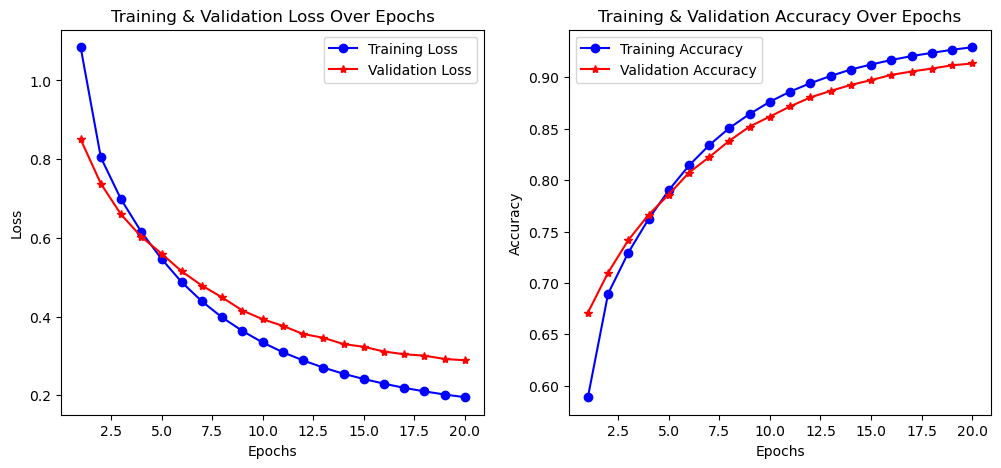

In [45]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a figure
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')  # Blue circles
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')  # Red stars
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')  # Blue circles
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')  # Red stars
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()

# Show plots
plt.show()


# Model 1
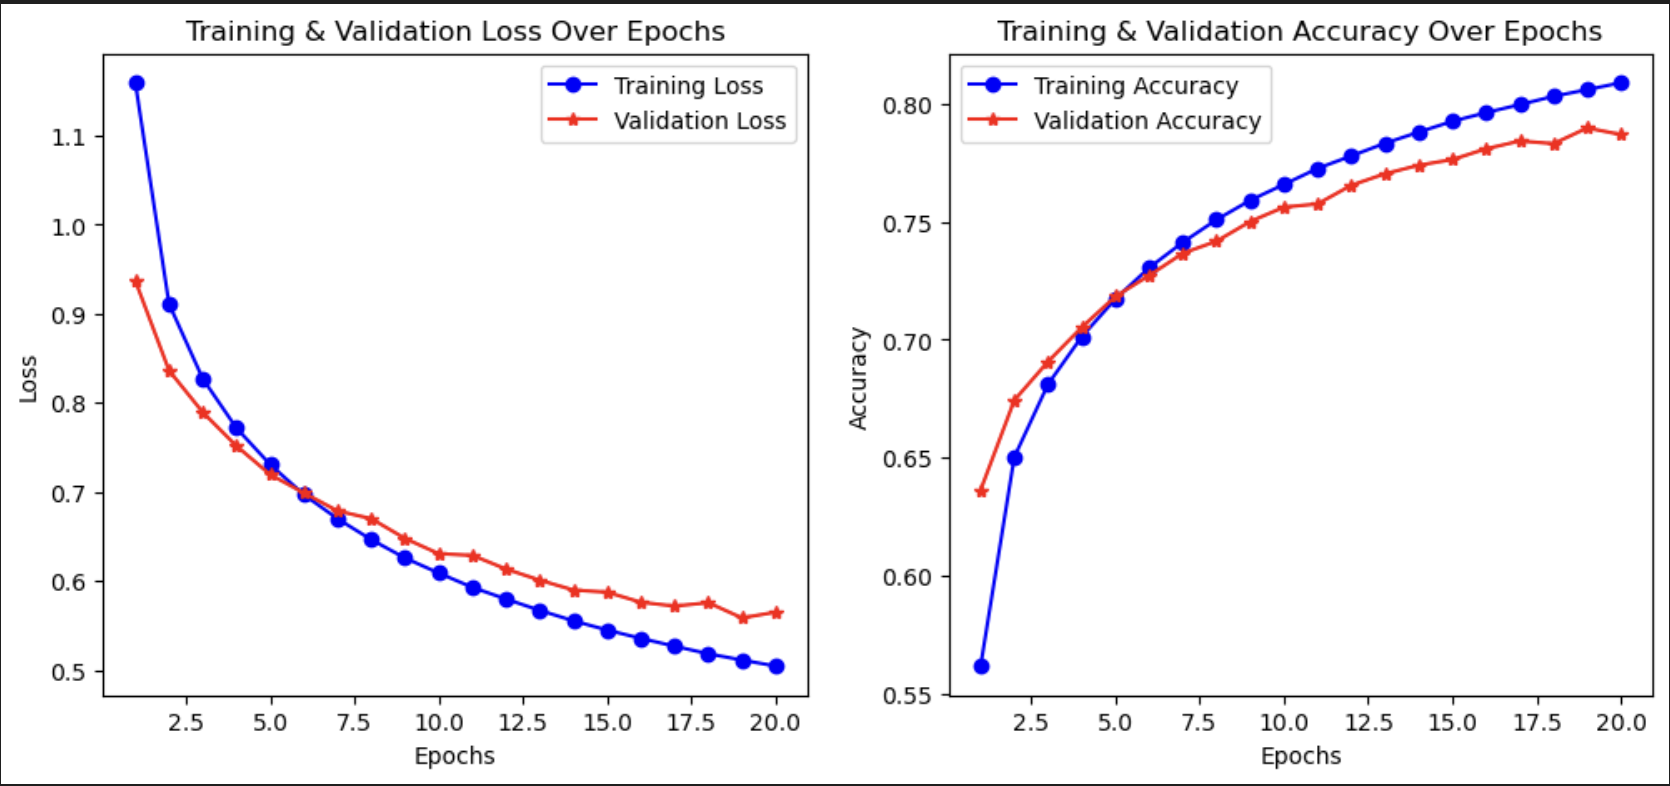

# Model 1
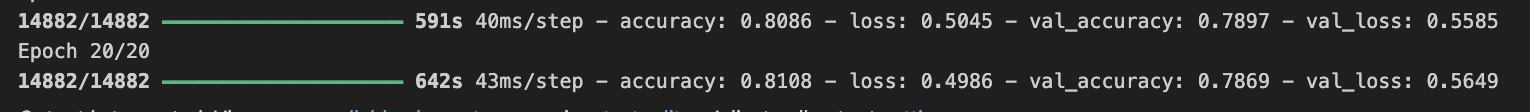

# Model 2

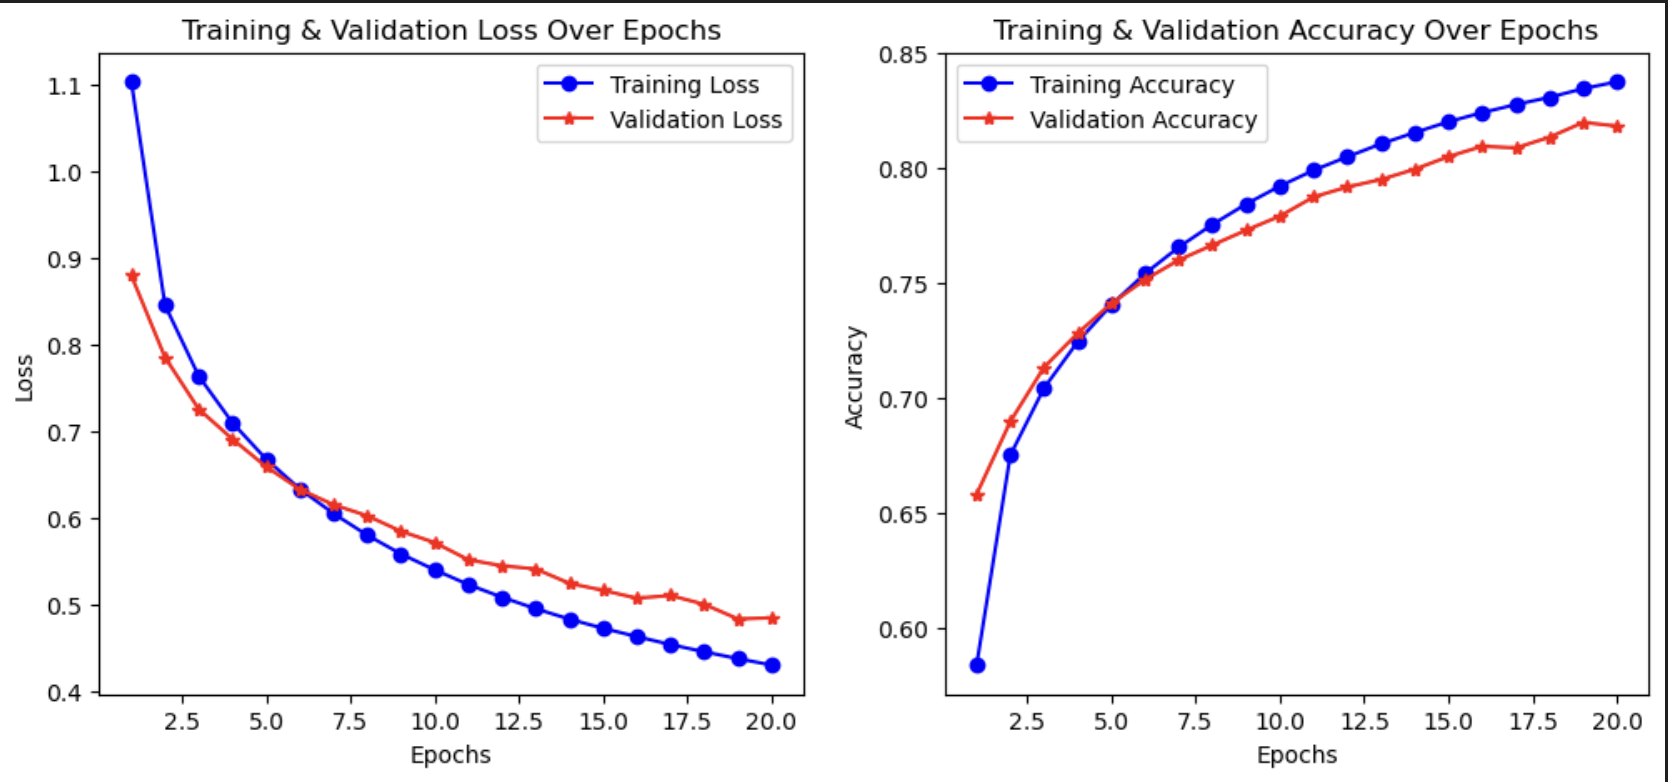

# Model 2
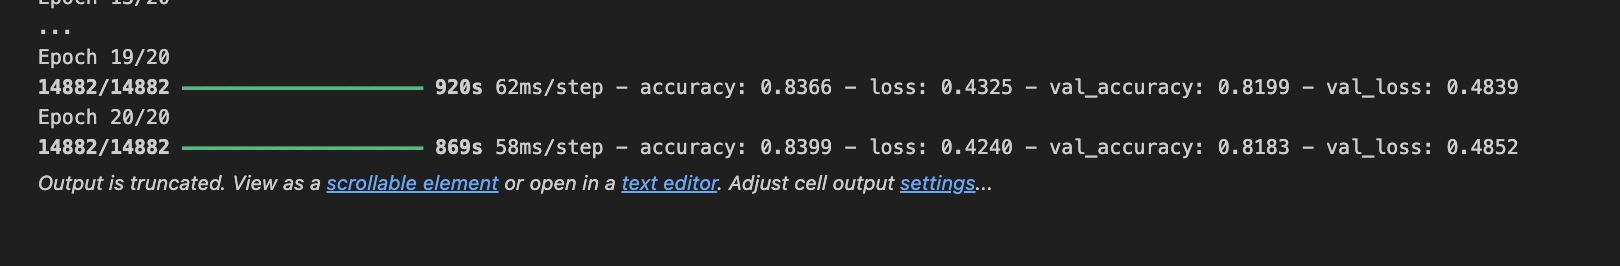

# Board States Easy to Beat
## Model 1



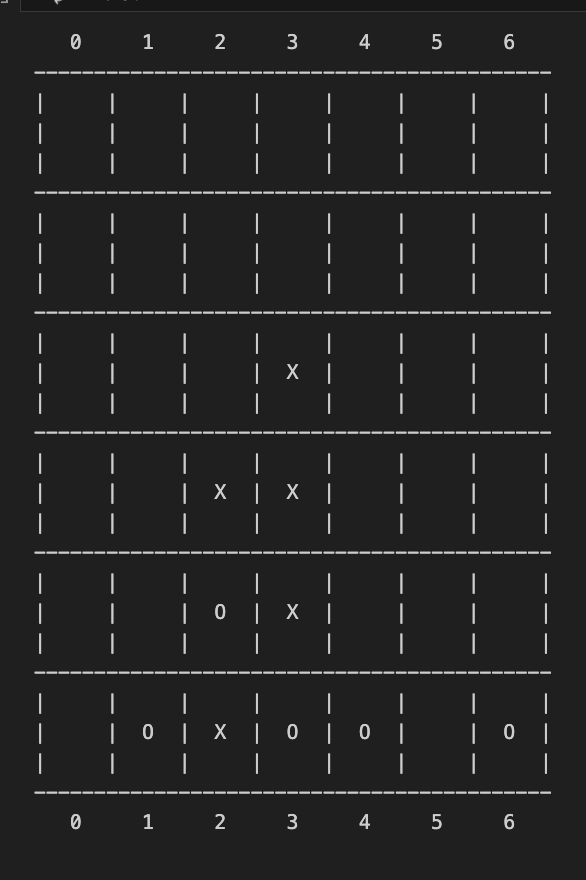
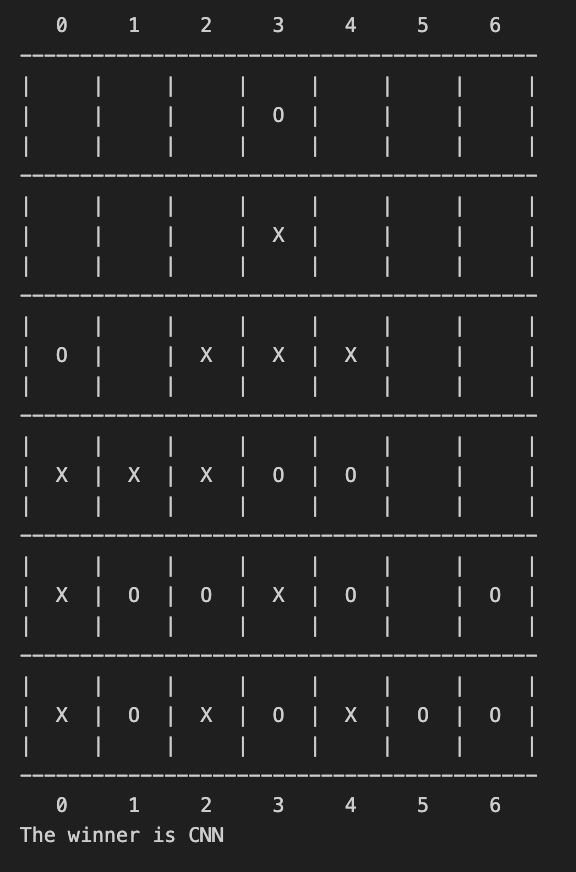
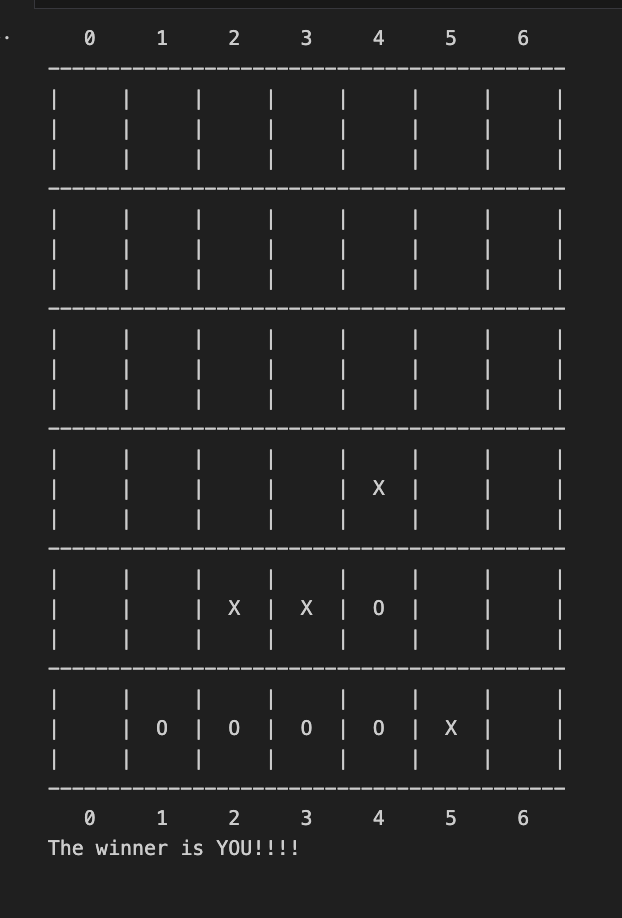
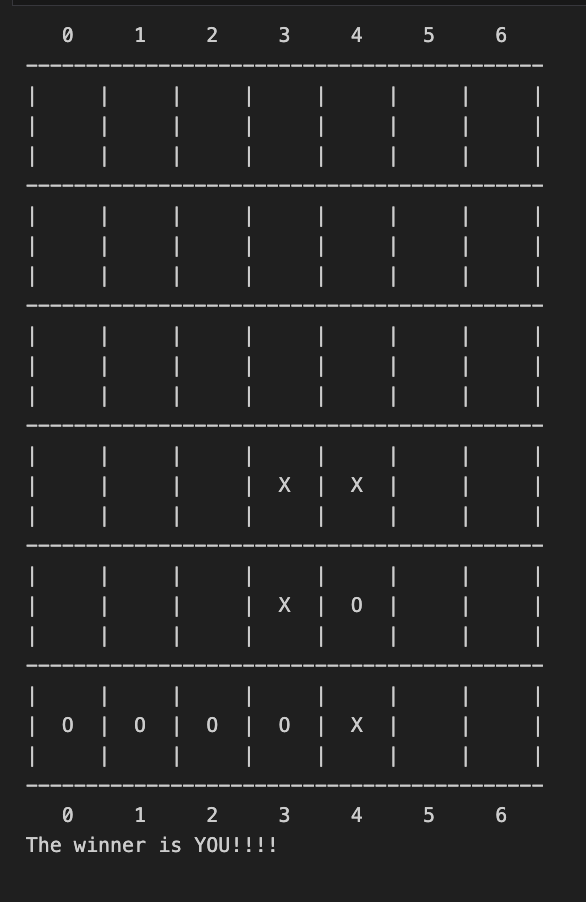

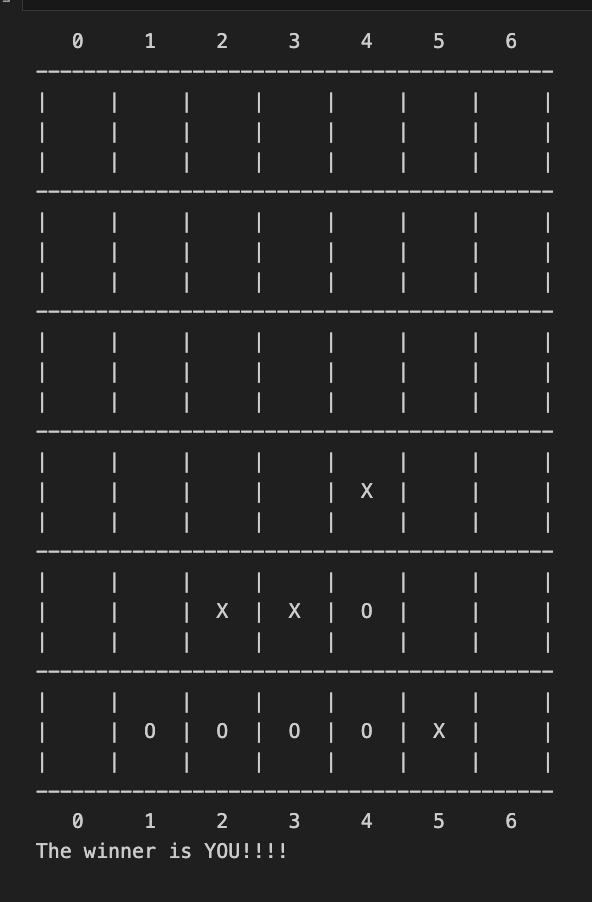
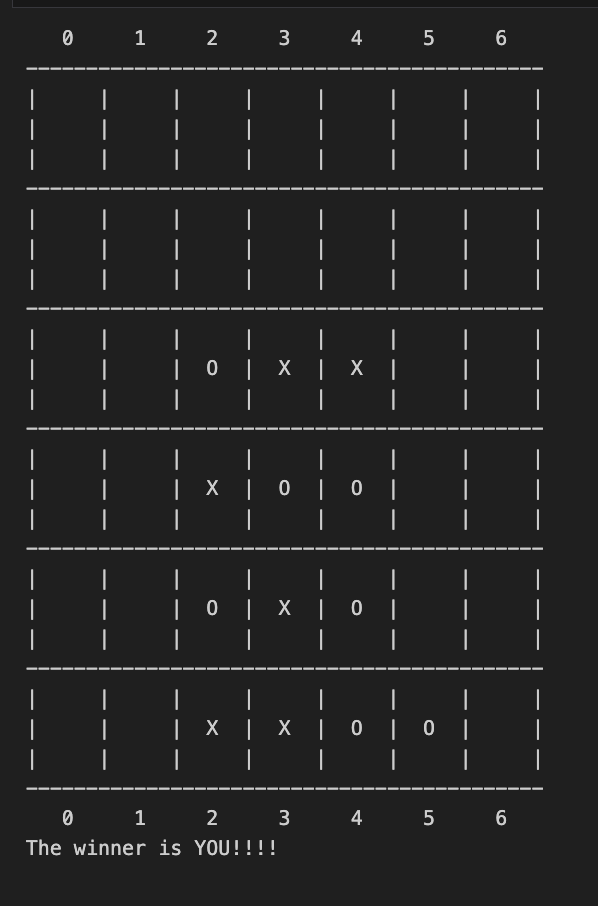

## Second model
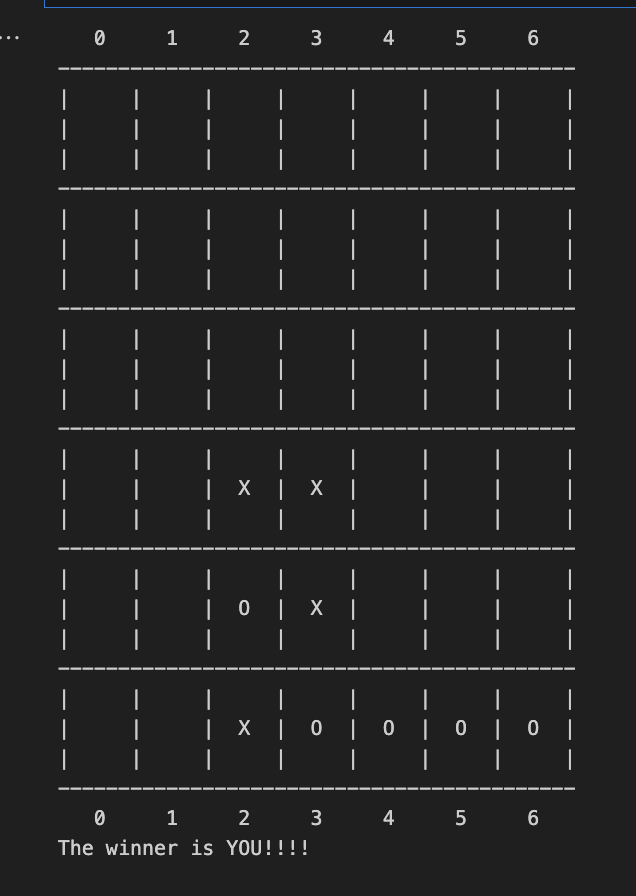
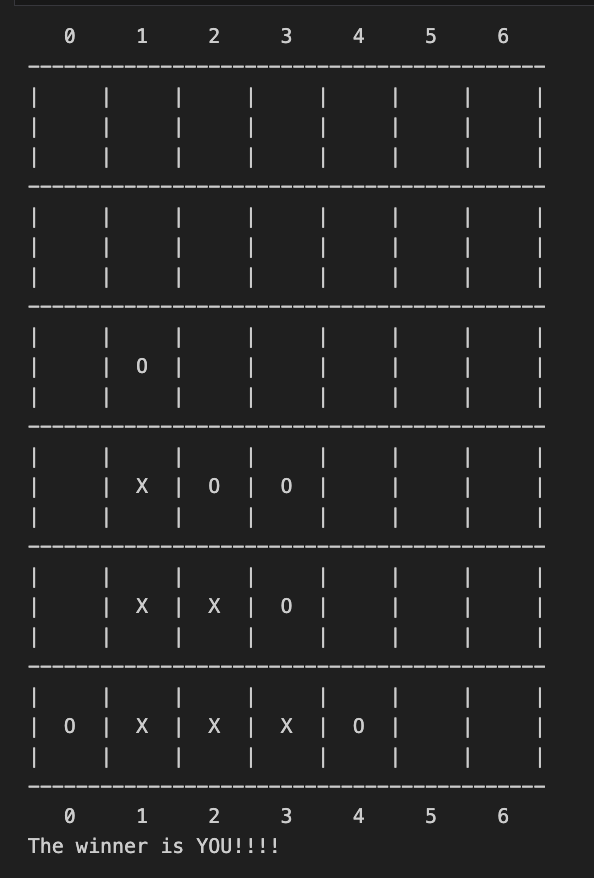